# Semantic Analysis via Text Classification

In this assignment, you will need to implement a review sentiment classification task via
[Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews). This dataset consists of reviews of fine foods from amazon. The
data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.
Reviews include product and user information, ratings, and a plain text review. It also includes
reviews from all other Amazon categories.

**Overall steps:** 1. Install/import corresponding packages. 2. Exploratory Data Analysis (EDA). 3.
Create labels based on the score, e.g., score>3: positive, score<3: negative. 4. Resampling for
imbalanced dataset if needed (Balancing positive and negative reviews). 5. Use 10-20%
sub-dataset and split it into training and test. 6. Use Text and created labels as features and
ground truth to complete the following tasks.

**Task 1 – TFIDF approach for this task.**
In this part, please implement the TFIDF based classification by using classical ML methods.

**Task 2 – Deep learning for review classification.**
In this task, you will need to design your deep learning framework for review
classification.


## Check GPU status

In [2]:
!nvidia-smi

Wed Mar  1 15:04:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.2 MB/s eta 0:00:00


## Import packages

In [4]:
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import string
import time
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Read data

In [5]:
data=pd.read_csv('https://web.cs.wpi.edu/~kmlee/data/Reviews.csv')


## EDA (Exploratory Data Analysis)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
data.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

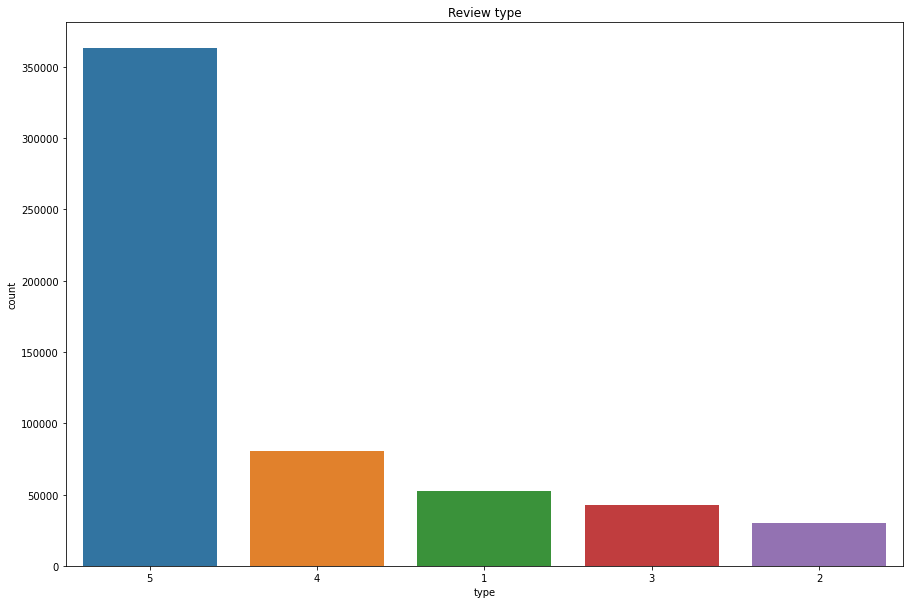

In [9]:
plt.figure(figsize=(15,10))
sns.countplot(
  x='Score',
  data=data,
  order=data.Score.value_counts().index
)
plt.xlabel("type")
plt.title("Review type");

## Create labels based on the score

### Positive: (4, 5)         Negative: (1, 2, 3)

In [13]:
data["review_type"] = data["Score"].apply(lambda x: "negative" if x < 4 else "positive")

In [14]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,review_type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,positive


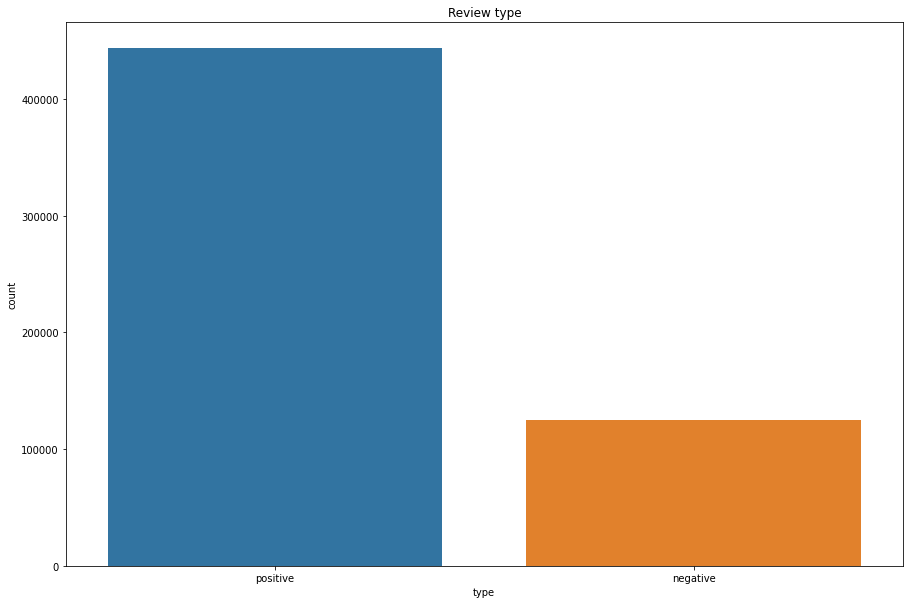

In [15]:
plt.figure(figsize=(15,10))
sns.countplot(
  x='review_type',
  data=data,
  order=data.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

## Random resampling for imbalanced dataset

In [16]:
positive_reviews = data[data.review_type == "positive"]
negative_reviews = data[data.review_type == "negative"]
positive_df = positive_reviews.sample(n=len(negative_reviews))
negative_df = negative_reviews
review_df = positive_df.append(negative_df).reset_index(drop=True)
review_df.shape

(249354, 11)

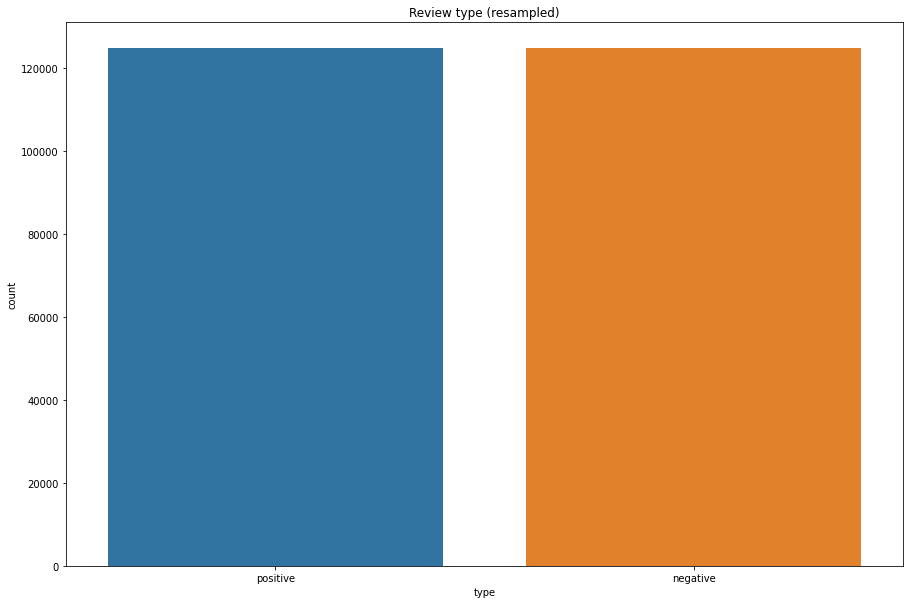

In [17]:
plt.figure(figsize=(15,10))
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

## Split dataset into train and test

In [18]:
## Removing html tags
review_df['Text']=review_df['Text'].apply(lambda row : re.sub('<.*?>','',row))

review_df.loc[review_df['review_type'] == "negative", 'label'] = 0
review_df.loc[review_df['review_type'] == "positive", 'label'] = 1
X_train, X_test, y_train, y_test = train_test_split(review_df[['Text']],review_df.label, 
                                                    test_size=0.2, shuffle=True)

In [19]:
X_train.head(5)

,Text
204150,Zico used to be my coconut water of choice. Wh...
66554,I love Quinoa Flakes. It is a fast breakfast ...
49688,"my ""big man"" is a 90 lb boxer with hip displas..."
112093,I have to watch the sodium in my diet and came...
136583,I've loved using NuStevia for 5 years.I tried ...


In [20]:
y_train.head(5)

204150    0.0
66554     1.0
49688     1.0
112093    1.0
136583    0.0
Name: label, dtype: float64

In [21]:
X_train=X_train[:int(len(X_train)*0.01)]
X_test=X_test[:int(len(X_test)*0.01)]
y_train=y_train[:int(len(y_train)*0.01)]
y_test=y_test[:int(len(y_test)*0.01)]

In [22]:
print ("Train sample num: ", X_train.shape)
print ("Test sample num: ", X_test.shape)

Train sample num:  (1994, 1)
Test sample num:  (498, 1)


In [23]:
X_train

,Text
204150,Zico used to be my coconut water of choice. Wh...
66554,I love Quinoa Flakes. It is a fast breakfast ...
49688,"my ""big man"" is a 90 lb boxer with hip displas..."
112093,I have to watch the sodium in my diet and came...
136583,I've loved using NuStevia for 5 years.I tried ...
...,...
194417,My 7 cats including a homeless stray did not t...
76778,I almost gave up on nursing but low in behold ...
91629,"Purchasing Lundberg Jubilee, Gourmet Blend of ..."
35784,this is exactyl what i have been searching for...


## TFIDF

### Preprocess data

In [31]:
def data_preprocessing(review):

    # package setting
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()

    # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review) #removing html tags
    review =  re.sub('[^A-Za-z0-9]+', ' ', review) #taking only words

    # lowercase
    review = review.lower()

    # tokenization
    tokens = nltk.word_tokenize(review) # converts review to tokens

    # stop_words removal
    review = [word for word in tokens if word not in stop_words] #removing stop words

    # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]

    # join words in preprocessed review
    review = ' '.join(review)

    return review

In [32]:
X_train['clean_text']=X_train['Text'].apply(lambda x: data_preprocessing(x))
X_test['clean_text']=X_test['Text'].apply(lambda x: data_preprocessing(x))

### Text Vectorization via TFIDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

vectorizer = TfidfVectorizer(min_df=10)
X_train_tfidf = vectorizer.fit_transform(X_train['clean_text'])
X_test_tfidf = vectorizer.transform(X_test['clean_text'])

In [34]:
y_train

204150    0.0
66554     1.0
49688     1.0
112093    1.0
136583    0.0
         ... 
194417    0.0
76778     1.0
91629     1.0
35784     1.0
231805    0.0
Name: label, Length: 1994, dtype: float64

### Train model

In [35]:
def run_model(model,X_train,X_test,y_train,y_test):
    if model == "lr":
        clf = LogisticRegression(penalty='l2',max_iter=1000)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [36]:
accuracy_lr=run_model("lr",X_train_tfidf,X_test_tfidf,y_train,y_test)

In [37]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'Accuracy']
x.add_row(['TFIDF-lr',str(format(accuracy_lr,'.3f'))])
print(x)

+----------+----------+
|  Model   | Accuracy |
+----------+----------+
| TFIDF-lr |  0.783   |
+----------+----------+


## Question 1

**Part 1**

Try two different methods such as `RandomForestClassifier`, `DecisionTreeClassifier`, `SVM`, etc. 
Can you achieve better performance than the previous model? Report your results in the table below.

In [38]:
#### Your code ####
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

def run_model(model,X_train,X_test,y_train,y_test):
    if model == "lr":
        clf = LogisticRegression(penalty='l2',max_iter=1000)
    
    elif model == "RFC":
        clf = RandomForestClassifier(n_estimators=100)
        
    elif model == "DTC":
        clf = DecisionTreeClassifier()
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

accuracy_RandomForest=run_model("RFC",X_train_tfidf,X_test_tfidf,y_train,y_test)
accuracy_DecisionTree=run_model("DTC",X_train_tfidf,X_test_tfidf,y_train,y_test)



#Hint: 
'''
def run_model(model,X_train,X_test,y_train,y_test):
    if model == "lr":
        clf = LogisticRegression(penalty='l2',max_iter=1000)
    
    elif model == "xxx":
        clf = xxxxxxxx
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

accuracy_xxx=run_model("xxx",X_train_tfidf,X_test_tfidf,y_train,y_test)

'''


'\ndef run_model(model,X_train,X_test,y_train,y_test):\n    if model == "lr":\n        clf = LogisticRegression(penalty=\'l2\',max_iter=1000)\n    \n    elif model == "xxx":\n        clf = xxxxxxxx\n    \n    clf.fit(X_train, y_train)\n    y_pred = clf.predict(X_test)\n    return accuracy_score(y_test, y_pred)\n\naccuracy_xxx=run_model("xxx",X_train_tfidf,X_test_tfidf,y_train,y_test)\n\n'

In [39]:
x.add_row(['TFIDF-lr',str(format(accuracy_lr,'.3f'))])
x.add_row(["Random Forest Classifier",str(format(accuracy_RandomForest,'.3f'))])
x.add_row(["Decision Tree Classifier",str(format(accuracy_DecisionTree,'.3f'))])

In [42]:
print (x)

+--------------------------+----------+
|          Model           | Accuracy |
+--------------------------+----------+
|         TFIDF-lr         |  0.783   |
| Random Forest Classifier |  0.747   |
| Decision Tree Classifier |  0.659   |
+--------------------------+----------+


## Deep Learning

## Question 2

Before we move on to model training part, please read the article below and answer the following questions.

https://www.zendesk.com/blog/machine-learning-and-deep-learning/

https://towardsdatascience.com/what-is-a-gpu-and-do-you-need-one-in-deep-learning-718b9597aa0d

**Part 1**

What are the important things that make deep learning different from other machine learning algorithms?

**Part 2**

What are the differences between a CPU and a GPU? Is the performance of GPU always superior to that of CPU? why?  

**Part 3**  

Why are GPUs particularly effective for performing efficient deep learning? Explain. 


In [ ]:
###Your answer here###

# Part 1
#   Well to start deep learning is a part of machine learning. Deep learning however doesn't require anyone to course correct it when its algorithm
#   is wrong. Machine learning uses algorithms for the data reading, parsing, and understanding. Deep learning "structures" algorithms in layers
#   for it to run.

# Part 2
#   A CPU or central processing unit is different from a GPU or graphics processing unit. A CPU is used for more general, specific calculations
#   and a GPU is better used for calculating things with large quantaties of daata. The performance of a GPU is not always better than a CPU, just
#   mostly when calculating things with large data sets which we do a lot in data science.

# Part 3
#   GPUs are ideal for deep learning since they can do multiple of these calculations at once, which is dramatically faster than the CPUs which arent
#   able to do this.






### Build networks

Now we can design a sample neural network architecture here. Let's think about what kind of architecture we want. We know our input dimension defines by tfidf, so the input to the first layer has to be of size same to the dimension. Our output is a class number (0 or 1), so our output can be 1 dimensional. Everything in between is up to us. And how do we decide what kind of architecture we want? We make it up! At least at first.

This example has 2 layers of size input_dim -> 100 -> 1. 

In [43]:
class mynetwork_1(nn.Module):
    def __init__(self,in_dim):
        super(mynetwork_1, self).__init__()
        self.input_dim = in_dim
        self.structure = nn.Sequential(
            nn.Linear(self.input_dim,100),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x
    
class mynetwork_2(nn.Module):
    def __init__(self,in_dim):
        super(mynetwork_2, self).__init__()
        self.input_dim = in_dim
        self.structure = nn.Sequential(
            nn.Linear(self.input_dim,100),
            nn.Sigmoid(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

## Question 3

**Part 1** 

Comparing the two network structures above, what is the difference between them? In other words, what is `nn.Sigmoid()`, why do we need it? 

In [ ]:
###Your answer here###

# The sigmoid function is a mathematical function that maps any input value to a value between 0 and 1.
# The sigmoid function is also commonly used as the "activation function" in neural networks.







Next we need to choose some training settings:

`batch size`

`number of epochs`

`learning rate`

`criterion (loss function)`

## Question 4

Please read the article below and answer the following questions.

https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/

https://towardsdatascience.com/what-are-hyperparameters-and-how-to-tune-the-hyperparameters-in-a-deep-neural-network-d0604917584a

What are `batch size`, `number of epochs`, `learning rate`? How do they impact the optimization of neural networks?

In [ ]:
###Your answer here###

# The batch size is the number of training samples processed before the model is updated.
# The number of epochs is the number of passes through the training dataset it does
# The learning rate is the step size each iteration does to minimize loss

# Having too large of a batch size will give a poor generalization. The number of epochs is directly related to how fit the 
# model is, too little will mean its under trained, and too much will be over trained, so its important to find the goldilocks.
# Too small a learning rate will mean the model will get stuck and maybe take too long to train. And too large means it could be
# quite inaccurate.






### Train network

In [61]:
# define networks
in_dim=X_train_tfidf.shape[1]
print(in_dim)
model_1 = mynetwork_1(in_dim).cuda()
model_2 = mynetwork_2(in_dim).cuda()

#training settings
batch_size = 55 # hyperparameter - changing it is optional for this assignment
num_epochs = 550 # hyperparameter - changing it is optional for this assignment
learning_rate = 1e-2 # hyperparameter - changing it is optional for this assignment
criterion = nn.MSELoss()
device="cuda"

# print interval during the training 
print_interval=20

1258


In [45]:
def train(X_train_tfidf, y_train, network, epochs, learning_rate, 
          batch_size, loss_function, print_interval):
  
    # convert numpy data to tensor data for pytorch
    X_train_tfidf = torch.tensor(scipy.sparse.csr_matrix.todense(X_train_tfidf)).float()
    train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train_tfidf),
                                                 torch.Tensor(y_train.to_numpy()))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                             shuffle=True)
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=1e-5)
    track_losses = np.zeros(epochs)

    start = time.time()
    for epoch in range(1, epochs+1):

        for batch_idx, (X, y) in enumerate(train_loader):
            # grab the x's for this batch
            data = X

            # find the predictions f(x) for this batch
            output = network(data.to(device))

            # find the loss
            loss = loss_function(output, y.view([-1, 1]).to(device))

            # compute the gradient and update the network parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # housekeeping - keep track of our losses and print them as we go
        training_loss = loss.item()**.5
        track_losses[epoch-1] = training_loss
        if epoch % print_interval == 0:
            print('epoch: %4d training loss:%10.3e time:%7.1f'%(epoch, training_loss, time.time()-start))

    return network, track_losses

In [55]:
network_1, losses = train(X_train_tfidf, y_train, model_1, num_epochs, learning_rate, batch_size, criterion, print_interval)
network_2, losses = train(X_train_tfidf, y_train, model_2, num_epochs, learning_rate, batch_size, criterion, print_interval)

epoch:   20 training loss: 3.244e-01 time:    1.4
epoch:   40 training loss: 2.268e-01 time:    3.2
epoch:   60 training loss: 1.715e-01 time:    4.9
epoch:   80 training loss: 1.563e-01 time:    6.2
epoch:  100 training loss: 2.144e-01 time:    7.6
epoch:  120 training loss: 3.046e-01 time:    8.9
epoch:  140 training loss: 2.081e-01 time:   10.2
epoch:  160 training loss: 2.300e-01 time:   11.6
epoch:  180 training loss: 2.016e-01 time:   12.9
epoch:  200 training loss: 2.405e-01 time:   14.2
epoch:  220 training loss: 1.823e-01 time:   15.8
epoch:  240 training loss: 1.990e-01 time:   17.6
epoch:  260 training loss: 1.931e-01 time:   19.1
epoch:  280 training loss: 2.156e-01 time:   20.4
epoch:  300 training loss: 2.297e-01 time:   21.8
epoch:  320 training loss: 2.321e-01 time:   23.1
epoch:  340 training loss: 1.911e-01 time:   24.5
epoch:  360 training loss: 2.855e-01 time:   25.8
epoch:  380 training loss: 2.094e-01 time:   27.2
epoch:  400 training loss: 2.956e-01 time:   28.7


In [46]:
def model_eva(X_test_tfidf,y_test,model):
    
    X_test_tfidf = torch.tensor(scipy.sparse.csr_matrix.todense(X_test_tfidf)).float().cuda()
    
    y_pred=model(X_test_tfidf).cpu().detach().numpy().reshape(-1)
    y_pred[y_pred>=0.5]=1.0
    y_pred[y_pred<0.5]=0.0
    
    return accuracy_score(y_test, y_pred)

In [56]:
accuracy_nn_1=model_eva(X_test_tfidf,y_test,model_1)
accuracy_nn_2=model_eva(X_test_tfidf,y_test,model_2)

In [57]:
x.add_row(['TFIDF-NN_1',str(format(accuracy_nn_1,'.3f'))])
x.add_row(['TFIDF-NN_2',str(format(accuracy_nn_2,'.3f'))])
x.del_row(3)
x.del_row(3)
print(x)

+--------------------------+----------+
|          Model           | Accuracy |
+--------------------------+----------+
|         TFIDF-lr         |  0.783   |
| Random Forest Classifier |  0.747   |
| Decision Tree Classifier |  0.659   |
|        TFIDF-NN_1        |  0.657   |
|        TFIDF-NN_2        |  0.659   |
+--------------------------+----------+


## Question 5

Design 2 different neural network structures and train them (e.g., different number of network layers, different number of neurons in hidden layers, different activation functions, etc.). Please report your results, you should be able to design one that is superior to `TFIDF-NN_1` and `TFIDF-NN_2`.

In [62]:
###Your code here###


class mynetwork_3(nn.Module):
    def __init__(self,in_dim):
        super(mynetwork_3, self).__init__()
        self.input_dim = in_dim
        self.structure = nn.Sequential(
            nn.Linear(self.input_dim,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

class mynetwork_4(nn.Module):
    def __init__(self,in_dim):
        super(mynetwork_4, self).__init__()
        self.input_dim = in_dim
        self.structure = nn.Sequential(
            nn.Linear(self.input_dim,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x




#Hint:
'''
class mynetwork_3(nn.Module):
    def __init__(self,in_dim):
        super(mynetwork_3, self).__init__()
        self.input_dim = in_dim
        self.structure = nn.Sequential(
            nn.Linear(self.input_dim,500),
            nn.ReLU(),
            nn.Linear(500,500),
            nn.ReLU(),
            nn.Linear(500, 1)
        )

    def forward(self, x):
        x = self.structure(x)
        return x
'''


model_3 = mynetwork_3(in_dim).cuda()
model_4 = mynetwork_4(in_dim).cuda()

network_3, losses = train(X_train_tfidf, y_train, model_3, num_epochs, learning_rate, batch_size, criterion, print_interval)
network_4, losses = train(X_train_tfidf, y_train, model_4, num_epochs, learning_rate, batch_size, criterion, print_interval)



epoch:   20 training loss: 4.290e-02 time:    2.0
epoch:   40 training loss: 1.382e-02 time:    4.5
epoch:   60 training loss: 1.224e-02 time:    6.3
epoch:   80 training loss: 2.672e-02 time:    8.1
epoch:  100 training loss: 2.520e-03 time:   10.0
epoch:  120 training loss: 1.178e-02 time:   11.8
epoch:  140 training loss: 3.497e-02 time:   13.7
epoch:  160 training loss: 3.043e-03 time:   15.8
epoch:  180 training loss: 9.351e-03 time:   18.2
epoch:  200 training loss: 1.503e-03 time:   20.0
epoch:  220 training loss: 9.887e-03 time:   21.8
epoch:  240 training loss: 4.479e-03 time:   23.6
epoch:  260 training loss: 2.639e-01 time:   25.5
epoch:  280 training loss: 1.165e-03 time:   27.3
epoch:  300 training loss: 1.531e-02 time:   29.6
epoch:  320 training loss: 3.271e-02 time:   31.9
epoch:  340 training loss: 2.757e-02 time:   33.7
epoch:  360 training loss: 1.215e-03 time:   35.6
epoch:  380 training loss: 2.548e-03 time:   37.4
epoch:  400 training loss: 1.102e-03 time:   39.2


In [65]:
accuracy_nn_3=model_eva(X_test_tfidf,y_test,model_3)
accuracy_nn_4=model_eva(X_test_tfidf,y_test,model_4)

x.add_row(['My NN model 1',str(format(accuracy_nn_3,'.3f'))])
x.add_row(['My NN model 2',str(format(accuracy_nn_2,'.3f'))])


In [67]:
x.del_row(5)
x.del_row(5)
print (x)

+--------------------------+----------+
|          Model           | Accuracy |
+--------------------------+----------+
|         TFIDF-lr         |  0.783   |
| Random Forest Classifier |  0.747   |
| Decision Tree Classifier |  0.659   |
|        TFIDF-NN_1        |  0.657   |
|        TFIDF-NN_2        |  0.659   |
|      My NN model 1       |  0.733   |
|      My NN model 2       |  0.659   |
+--------------------------+----------+
